В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import joblib

Area under ROC score on Train dataset: 0.9252916244441668%


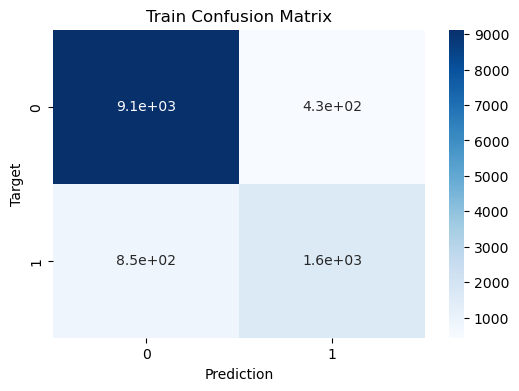

Area under ROC score on Validation dataset: 0.921749777076617%


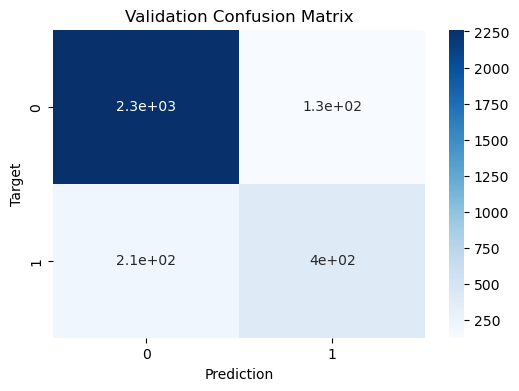

['log_reg_pipeline.joblib']

In [11]:
raw_df = pd.read_csv('train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[3:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender', 'NumOfProducts']
binary_cols = ['HasCrCard', 'IsActiveMember']

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bin', 'passthrough', binary_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_df, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)[:, 1]
    roc_auc = roc_auc_score(targets, probs)
    print(f"Area under ROC score on {name} dataset: {roc_auc}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds


# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_df, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_df, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'log_reg_pipeline.joblib')

In [12]:
?roc_auc_score

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.9263827686614878%


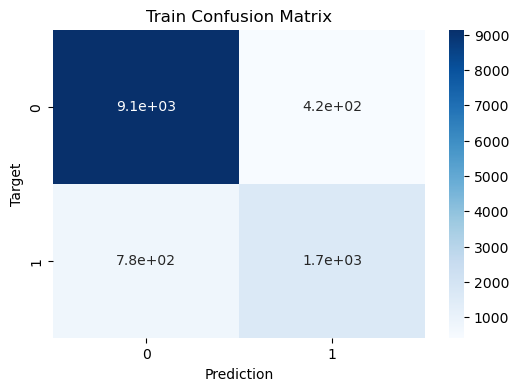

Area under ROC score on Validation dataset: 0.9228993758145279%


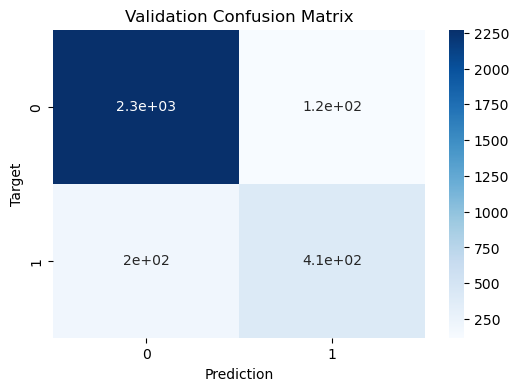

In [13]:
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer_2 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bin', 'passthrough', binary_cols)
    ])


model_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier', LogisticRegression(solver='liblinear'))
])


model_pipeline_2.fit(train_df, train_targets)
train_preds = predict_and_plot(model_pipeline_2, train_df, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline_2, val_df, val_targets, 'Validation')

Як на мене, модель добре генералізує. Високе значення аук є як у тренувальних, так і у валіаційних даних. Отже модель працює дуже навіть непогано

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.9316600027522814%


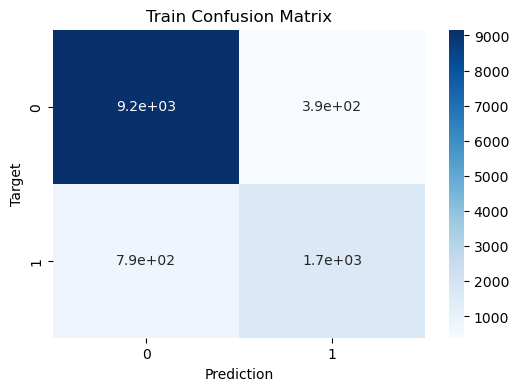

Area under ROC score on Validation dataset: 0.926991563207353%


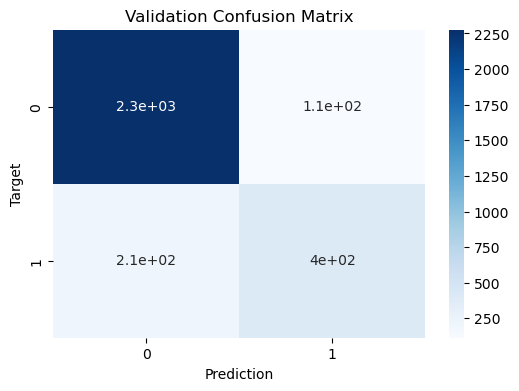

In [16]:
numeric_transformer_4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4)),
    ('scaler', StandardScaler())
     ])

preprocessor_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bin', 'passthrough', binary_cols)
    ])

model_pipeline_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_4.fit(train_df, train_targets)
train_preds = predict_and_plot(model_pipeline_4, train_df, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline_4, val_df, val_targets, 'Validation')

Тут значення аук уже повністю зрівнялися у обох наборів

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

reg_df = pd.read_csv('regression_data.csv')
X = reg_df.drop('target', axis=1)
y = reg_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

reg_pipeline_5 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

reg_pipeline_5.fit(X_train, y_train)

y_train_pred = reg_pipeline_5.predict(X_train)
y_val_pred = reg_pipeline_5.predict(X_val)

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")

Train RMSE: 0.0000
Validation RMSE: 13.2204


In [21]:
np.mean(X), np.std(X)

C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(feature_1   -0.082039
 feature_2   -0.017872
 feature_3    0.092293
 feature_4   -0.076084
 feature_5    0.053098
 dtype: float64,
 feature_1    0.937559
 feature_2    1.061748
 feature_3    0.974757
 feature_4    0.907052
 feature_5    1.000597
 dtype: float64)

Модель нехороша, модель чудово працює на тренувальних даних, а на валідаційних є досить велика помилка. Це оверфіт.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [28]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

def evaluate_reg_model(model, name):
    pipe = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=20)),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    val_score = mean_squared_error(y_val, pipe.predict(X_test))
    print(f"{name} Validation RMSE: {val_score:.4f}")
    return pipe

lasso_model = evaluate_reg_model(Lasso(alpha=0.1), "Lasso")
ridge_model = evaluate_reg_model(Ridge(alpha=0.1), "Ridge")
elastic_model = evaluate_reg_model(ElasticNet(alpha=0.1, l1_ratio=0.5), "ElasticNet")

Lasso Validation RMSE: 1.6310
Ridge Validation RMSE: 3668.6333
ElasticNet Validation RMSE: 276.0510


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.391e+01, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(


Найкраще генералізує модель Ласа. Напевно це через те, що у 20-степеневого поліному виникло дуже багато лишніх змінних, і саме модель Ласо, який дає вагу 0 змінним які не несуть особливого внеску в таргет, що покращує модель